In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
import re
import os

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [4]:
path = "drive/MyDrive/IAS/Semester3/NLP/data/twitter.csv"
df_training = pd.read_csv(path)
df_training = df_training.rename(columns={'class': 'label'})
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   label               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
df_training['label'].value_counts()


1    19190
2     4163
0     1430
Name: label, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f723b631f60>],
      dtype=object)

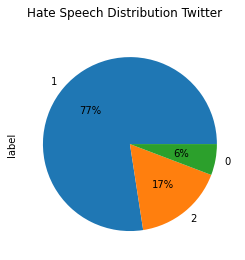

In [ ]:
df_training.label.value_counts().plot(kind='pie', subplots=True,autopct='%1.0f%%', title='Hate Speech Distribution Twitter')

## class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
# df_training = df_training[['class','tweet']]
# df_training.replace({'class' : { 0 : 1, 1 : 0, 2 : 0 }},inplace=True)
# df_training['class'].value_counts()

In [ ]:
def filter_hatespeech_tweets(df):
    
    def filter_tweets(tweet):
        return re.sub('@.\:|!|@\w+:|@[\w]*|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', tweet)

    def postprocess_filter_tweets(tweet):
        
        return df

    df['tweet'] = df['tweet'].apply(filter_tweets)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    
    return df

df_training = filter_hatespeech_tweets(df_training)

In [ ]:
TEXT_COLUMN = "tweet"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
print(df_training.head())

Converting to lower-case
   Unnamed: 0  count  ...  label                                              tweet
0           0      3  ...      2     as a woman you shouldn't complain about cle...
1           1      3  ...      1     boy dats cold...tyga dwn bad for cuffin dat...
2           2      3  ...      1     dawg   you ever fuck a bitch and she start ...
3           3      3  ...      1                             she look like a tranny
4           4      6  ...      1     the shit you hear about me might be true or...

[5 rows x 7 columns]


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet,doc_len
0,0,3,0,0,3,2,as a woman you shouldn't complain about cle...,25
1,1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat...,16
2,2,3,0,3,0,1,dawg you ever fuck a bitch and she start ...,21
3,3,3,0,2,1,1,she look like a tranny,9
4,4,6,0,6,0,1,the shit you hear about me might be true or...,26


## Splitting the data

In [ ]:
seed = 11
test_size = 0.2
#categories = ['hate speech', 'offensive language', 'neither']
categories = [0,1,2]
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    return train.tweet, train.label, test.tweet, test.label

In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, seed=seed, test_size=test_size)

In [ ]:
train_targets.values

array([1, 1, 2, ..., 1, 1, 1])

In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]], [s.index[2], s[2]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(data, label):
    # fill up the missing values
    X = data.fillna("_na_").values
    total_tweets = df_training.tweet.fillna("_na_").values
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(list(total_tweets))
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X = pad_sequences(X, maxlen=maxlen)
    print(X.shape)
    
    # Get the target values
    y = pd.get_dummies(label.values)
    print(y.shape)
    #le = LabelEncoder()
    #le.fit(Y_train)
    #encoded_Y = le.transform(Y_train)
    return X,y,vocab_size
    

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, y_train, vocab_size = encode(train, train_targets)
X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'a': 1, 'i': 2, 'the': 3, 'bitch': 4, 'you': 5, 'to': 6, 'and': 7, 'my': 8, 'that': 9, 'in': 10, 'is': 11, 'bitches': 12, 'like': 13, 'http:': 14, 'of': 15, 'on': 16, 'me': 17, 'be': 18, 'for': 19, 'this': 20, 'hoes': 21, 'with': 22, 'pussy': 23, 'it': 24, 'hoe': 25, "i'm": 26, 'your': 27, 'ass': 28, 'if': 29, 'all': 30, 'just': 31, 'but': 32, "don't": 33, 'get': 34, 'up': 35, 'they': 36, 'so': 37, 'fuck': 38, 'when': 39, 'these': 40, 'got': 41, 'u': 42, 'no': 43, 'was': 44, 'not': 45, 'she': 46, 'are': 47, 'shit': 48, 'at': 49, 'her': 50, 'nigga': 51, 'have': 52, 'out': 53, 'lol': 54, '"': 55, 'about': 56, "ain't": 57, 'some': 58, 'trash': 59, 'he': 60, '&amp;': 61, 'what': 62, 'can': 63, 'know': 64, 'do': 65, 'we': 66, 'niggas': 67, 'how': 68, 'love': 69, "it's": 70, 'or': 71, 'as': 72, 'them': 73, 'one': 74, 'who': 75, 'fucking': 76, 'yo': 77, 'go': 78, 'want': 79, 'from': 80, "can't": 81, 'bitch.': 82, 'his': 83, 'why': 84, 'then': 85, 'bad': 86, "you're": 87, 'good': 88, 'still':

In [ ]:
y_train

,0,1,2
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
19820,0,1,0
19821,0,1,0
19822,0,1,0
19823,0,1,0


## Creating the model

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 32
lr = 0.001


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=X_train.shape[1]),
        tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        tf.keras.layers.Dense(3, activation = 'softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 21, 300)           9432300   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 9,525,935
Trainable params: 9,525,935
Non-trainable params: 0
_________________________________________________________________


In [ ]:


#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      validation_split=0.25,
      batch_size=batch_size)

Epoch 1/4
465/465 [==============================] - 65s 133ms/step - loss: 1.9562 - accuracy: 0.7888 - precision_6: 0.7934 - recall_6: 0.6859 - val_loss: 0.6397 - val_accuracy: 0.8765 - val_precision_6: 0.8978 - val_recall_6: 0.8541
Epoch 2/4
465/465 [==============================] - 63s 135ms/step - loss: 0.4956 - accuracy: 0.9124 - precision_6: 0.9301 - recall_6: 0.9025 - val_loss: 0.4803 - val_accuracy: 0.8667 - val_precision_6: 0.8845 - val_recall_6: 0.8485
Epoch 3/4
465/465 [==============================] - 61s 131ms/step - loss: 0.2888 - accuracy: 0.9353 - precision_6: 0.9513 - recall_6: 0.9285 - val_loss: 0.4398 - val_accuracy: 0.8751 - val_precision_6: 0.8955 - val_recall_6: 0.8588
Epoch 4/4
465/465 [==============================] - 61s 131ms/step - loss: 0.2183 - accuracy: 0.9478 - precision_6: 0.9577 - recall_6: 0.9400 - val_loss: 0.4771 - val_accuracy: 0.8729 - val_precision_6: 0.8860 - val_recall_6: 0.8533


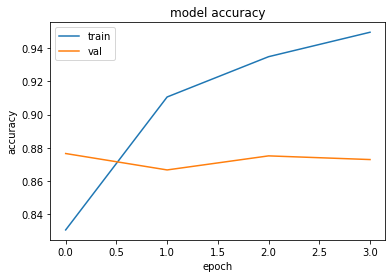

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

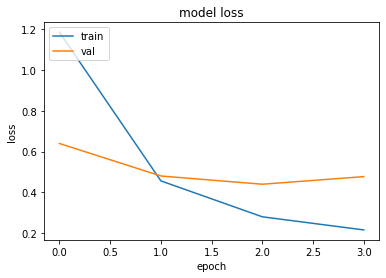

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))


155/155 [==============================] - 1s 7ms/step - loss: 0.5062 - accuracy: 0.8580 - precision_6: 0.8764 - recall_6: 0.8386
loss: 0.5062370896339417 accuracy: 0.8579786419868469 precision: 0.8764495253562927 recall: 0.8386120796203613


In [ ]:
Y_pred = model.predict(X_test)


In [ ]:
Y_pred

array([[1.39905866e-02, 9.85965014e-01, 4.44164289e-05],
       [3.02430009e-03, 9.96943772e-01, 3.19904429e-05],
       [1.11135364e-01, 3.63716096e-01, 5.25148571e-01],
       ...,
       [7.68109187e-02, 9.21388745e-01, 1.80038135e-03],
       [1.43635459e-02, 9.85515893e-01, 1.20588884e-04],
       [2.33436711e-02, 9.74744678e-01, 1.91162119e-03]], dtype=float32)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

array([1, 1, 2, ..., 1, 1, 1])

In [ ]:
categories = ['hate speech', 'offensive language', 'neither']
 
report = classification_report(test_targets.values, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
hate speech,0.486486,0.177632,0.260241,304.000000
offensive language,0.889079,0.946178,0.916740,3846.000000
neither,0.743692,0.693928,0.717949,807.000000
accuracy,0.857979,0.857979,0.857979,0.857979
macro avg,0.706419,0.605913,0.631643,4957.000000
weighted avg,0.840720,0.857979,0.844115,4957.000000


In [ ]:
name = 'drive/MyDrive/IAS/Semester3/NLP/matrix_report_lstm_twitter.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['learning_rate'] = lr
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['test_size'] = test_size
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['test_size'] = len(test)
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['train_class_proportion_' + categories[2]] = round(train_class_distribution[2][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[2]] = round(test_class_distribution[2][1], 2)

In [ ]:
df_results.head()

,loss,accuracy,precision_6,recall_6,val_loss,val_accuracy,val_precision_6,val_recall_6,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_proportion_hate speech,train_class_proportion_offensive language,train_class_proportion_neither,test_class_proportion_hate speech,test_class_proportion_offensive language,test_class_proportion_neither
0,1.185322,0.830508,0.850054,0.788136,0.639747,0.876538,0.897795,0.854146,0.001,4,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
1,0.456311,0.910613,0.927312,0.898372,0.480264,0.866653,0.884543,0.848497,0.001,4,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
2,0.280037,0.934894,0.949356,0.926688,0.439819,0.875126,0.895456,0.858786,0.001,4,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
3,0.215711,0.949623,0.958687,0.941149,0.477114,0.872907,0.886049,0.853339,0.001,4,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16


In [ ]:
name = 'drive/MyDrive/IAS/Semester3/NLP/training_logs_lstm_twitter.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

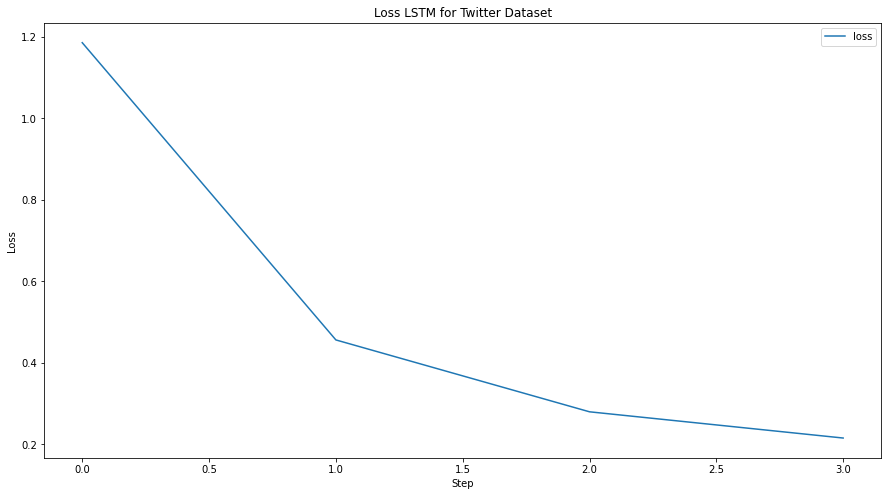

In [ ]:
fig, axs = plt.subplots(1,1)
path = 'drive/MyDrive/IAS/Semester3/NLP/training_logs_lstm_twitter.csv'
plot_loss(path, axs, title='Loss LSTM for Twitter Dataset')

## Classication of Movies

### Load Movies

In [ ]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[-1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [ ]:
pathes = ['drive/MyDrive/IAS/Semester3/NLP/movies/racism', 'drive/MyDrive/IAS/Semester3/NLP/movies/hate_speech', 'drive/MyDrive/IAS/Semester3/NLP/movies/friendship']

In [ ]:
movie_metadata_df = read_movie_files(pathes)
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,Falling Down,2024,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
1,Donnie Brasco,2202,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
2,Cruel Intentions,1358,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
3,Dragged Across Concrete,1527,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
4,Django Unchained,1893,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7285fcf668>],
      dtype=object)

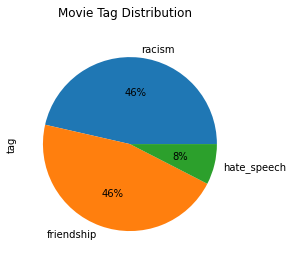

In [ ]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [ ]:
path = 'drive/MyDrive/IAS/Semester3/NLP/data/all_movies.csv'
all_movie_data = pd.read_csv(path, index_col=0)

In [ ]:
all_movie_data.head()

,movie_name,index,utterance,count_utterances,tag
0,12 Angry Men,0,"Thank you very much, sir.",2065,racism
1,12 Angry Men,1,You did a wonderful job. Wonderful.,2065,racism
2,12 Angry Men,2,Shh. Shh.,2065,racism
3,12 Angry Men,3,"We did it, Pete. We did it.",2065,racism
4,12 Angry Men,4,"For a moment, we had our doubts.",2065,racism


In [ ]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    #doc_len = movie_df.dialog.apply(lambda words: len(words.split(" ")))
    #max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(utterances)


 
    utterances = tokenizer.texts_to_sequences(utterances)
    # Pad the sentences
    utterances = pad_sequences(utterances, maxlen=maxlen)
    #print(utterances.shape)
    vocab_size = len(tokenizer.word_index) + 1
    #print(tokenizer.word_index)
    

    predictions = model.predict(utterances)
    predictions = np.argmax(predictions, axis=1)
    #print(predictions)


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_twitter': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']

    return movie_df
    

## Annotate Movies

In [ ]:
movie_df = pd.read_csv(pathes[0]+'/12 Angry Men_conv.csv')

In [ ]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [ ]:
annotate_single_movie(movie_df)

,dialog,label_LSTM_twitter
0,"Thank you very much, sir.",hate speech
1,You did a wonderful job. Wonderful.,offensive language
2,Shh. Shh.,neither
3,"We did it, Pete. We did it.",offensive language
4,"For a moment, we had our doubts.",offensive language
...,...,...
2060,What's your name?,offensive language
2061,Davis.,offensive language
2062,My name's McCardle.,neither
2063,"Well, so long.",offensive language


In [ ]:
def movie_data_cleansing(df):
    df = df.replace(r'<[^\\]>', '', regex=True)
    df = df.replace(r'<\\.*>', '', regex=True)
    return df

In [ ]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_LSTM_twitter.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [ ]:
movies_annotated_df = annotate_movies(movie_metadata_df)

1 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Falling Down_conv.csv racism Falling Down
2 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Donnie Brasco_conv.csv racism Donnie Brasco
3 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Cruel Intentions_conv.csv racism Cruel Intentions
4 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Dragged Across Concrete_conv.csv racism Dragged Across Concrete
5 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Django Unchained_conv.csv racism Django Unchained
6 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Enter the Dragon_conv.csv racism Enter the Dragon
7 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Crash_conv.csv racism Crash
8 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Chinatown_conv.csv racism Chinatown
9 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Children of Men_conv.csv racism Children of Men
10 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Empire of the Sun_conv.csv racism Empire of the Sun
11 25

In [ ]:
movies_annotated_df.to_csv('drive/MyDrive/IAS/Semester3/NLP/annotations/annotations_lstm_twitter.csv')